This is a response to the DataQuest Guided Project, Answering Business Questions using SQL.  The problem provided a dataset with 11 tables in the Chinook database, each linked to at least one other table by a common variable.  The question gives four new artists that could be sold by a record store in the United States and the genre of their music, and asks which three to pick:
Regal (Hip-Hop), Red Tone (Punk), Meteor and the Girls (Pop), Slim Jim Bites (Blues)

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#function allowing us to input a query from the chinook db
#and print into a dataframe automatically

def run_query(q):
    conn = sqlite3.connect('chinook.db')
    return pd.read_sql_query(q, conn)

In [3]:
#function that defines permanent views

def run_command(c):
    conn = sqlite3.connect('chinook.db')
    conn.isolation_level = None
    conn.execute(c)

In [4]:
#query to quickly check db table and view state throughout process

def show_tables():
    d = 'SELECT name, type FROM sqlite_master WHERE type IN ("table", "view");'
    return run_query(d)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [5]:
q = "WITH \
    n AS (SELECT \
            g.name genre_name, \
            COUNT(*) number_sold_in_usa \
          FROM genre g \
          INNER JOIN track t ON t.genre_id = g.genre_id \
          INNER JOIN invoice_line il ON il.track_id = t.track_id \
          INNER JOIN invoice i ON i.invoice_id = il.invoice_id \
          WHERE i.billing_country = 'USA' \
          GROUP BY t.genre_id) \
    SELECT \
        genre_name, \
        number_sold_in_usa, \
        (CAST(number_sold_in_usa AS FLOAT)/1051)*100 AS percentage_sold_in_usa \
    FROM n;"

usa_genres = run_query(q)

In [6]:
usa_genres

,genre_name,number_sold_in_usa,percentage_sold_in_usa
0,Rock,561,53.377735
1,Jazz,14,1.332065
2,Metal,124,11.798287
3,Alternative & Punk,130,12.369172
4,Blues,36,3.425309
5,Latin,22,2.093245
6,Reggae,6,0.570885
7,Pop,22,2.093245
8,Soundtrack,2,0.190295
9,Easy Listening,13,1.236917


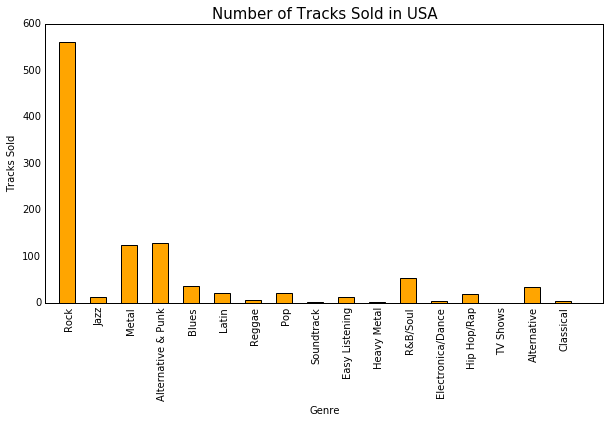

In [7]:
#bar graph of absolute numbers

from numpy import arange

fig, ax = plt.subplots(figsize=(10,5))

bar_positions = arange(17) + 0.45
bar_heights = usa_genres['number_sold_in_usa'].values
ax.bar(bar_positions, bar_heights, 0.5, color=(1,165/255,0))

xtick_pos = arange(17)+0.75
ax.set_xticks(xtick_pos)
ax.set_xticklabels(usa_genres['genre_name'], rotation=90)
plt.xlabel("Genre")

ax.tick_params(bottom='off', top='off', left='off', right='off')

plt.ylabel("Tracks Sold")

plt.title("Number of Tracks Sold in USA", fontsize=15)

plt.show()

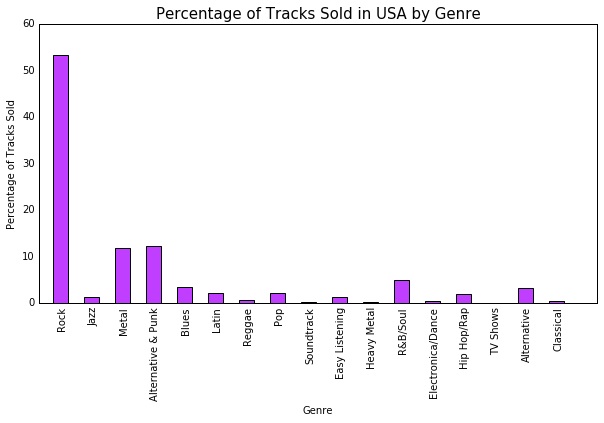

In [8]:
#bar graph of percentages

fig, ax = plt.subplots(figsize=(10, 5))

bar_positions = arange(17) + 0.45
bar_heights = usa_genres['percentage_sold_in_usa'].values
ax.bar(bar_positions, bar_heights, 0.5, color=(191/255, 62/255, 255/255))

xtick_pos = arange(17)+0.75
ax.set_xticks(xtick_pos)
ax.set_xticklabels(usa_genres['genre_name'], rotation=90)
plt.xlabel("Genre")

ax.tick_params(bottom='off', top='off', left='off', right='off')

plt.ylabel("Percentage of Tracks Sold")

plt.title("Percentage of Tracks Sold in USA by Genre", fontsize=15)

plt.show()

Based on these results, the punk artist (Red Tone), the Blues artist (Slim Jim Bites), and the Pop artist (Meteor and the Girls) should be added to the store for the highest chance of sales.

The next question is whether any particular sales agents are performing particularly better or worse.

In [9]:
#query that calculates total dollar amount of sales earned by each sales support agent
q = "SELECT \
        e.first_name || ' ' || e.last_name \
            AS employee_name, \
        e.hire_date, \
        SUM(i.total) \
            AS total_sales\
    FROM invoice i \
        INNER JOIN customer c ON c.customer_id = i.customer_id \
        INNER JOIN employee e on e.employee_id = c.support_rep_id \
    GROUP BY c.support_rep_id \
    ORDER BY total_sales DESC"

sales_support_agents = run_query(q)
sales_support_agents

,employee_name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


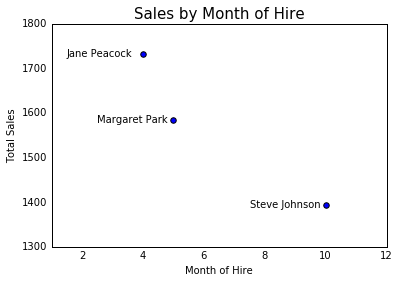

In [10]:
#to be able to visualize the relationship between hire date and total
#sales, I need to create lists of iterable float values for a scatter
#plot to use as x and y values.

dates = sales_support_agents['hire_date'].values
month_of_hire = []
for item in dates:
    month_of_hire.append(float(item[5:7]))

sales = sales_support_agents['total_sales'].values
employee_names = sales_support_agents['employee_name'].values

fig, ax = plt.subplots()
ax.scatter(month_of_hire, sales, s=30)
plt.title('Sales by Month of Hire', fontsize=15)
ax.set_xlabel('Month of Hire')
ax.set_xlim(1,12)
ax.set_ylim(1300,1800)
ax.set_ylabel('Total Sales')
ax.tick_params(bottom='off', top='off', left='off', right='off')

for i, txt in enumerate(employee_names):
    ax.annotate(txt, (month_of_hire[i]-2.5, sales[i]-5))

plt.show()

The sales agents do have different amounts of total sales, but it corresponds with when they were hired.  Jane Peacock, who was hired in early April, has the most sales; Margaret Park, who has been working since early May, is about 150 behind Peacock; and Steve Johnson, hired in October, has the lowest total sales, about 190 behind Park.  This makes sense because if someone was working longer, they would have more time to make more sales.  The better question to evaluate the rate at which an agent earns sales would be to divide their total sales by the total amount of time that they have been working, but since I do not have a date for when this database was created I can't do that here.

The next prompt is to calculate total number of customers, total value of sales, and average value of sales per customer with the countries with only one customer grouped together in "Other."

In [11]:
c = "CREATE VIEW country_groups AS \
        WITH customer_counts AS ( \
        SELECT \
            country, \
            COUNT(customer_id) counted \
        FROM customer c \
        GROUP BY country \
        ), \
        total_sales AS ( \
        SELECT \
            CASE \
                WHEN cc.counted = 1 \
                    THEN 'Other' \
                ELSE c.country \
                END AS country_redefined, \
            cc.counted, \
            SUM(i.total) AS total_sales \
        FROM customer c \
            INNER JOIN invoice i on i.customer_id = c.customer_id \
            INNER JOIN customer_counts cc ON cc.country = c.country \
        GROUP BY c.country \
        ) \
    SELECT * FROM total_sales;"

run_command(c)

OperationalError: table country_groups already exists

In [12]:
c = "CREATE VIEW customer_data AS \
    WITH n AS \
        (SELECT \
            CASE \
                WHEN country_redefined = 'Other' \
                    THEN 1 \
                ELSE 0 \
                END AS forced_order, \
            country_redefined, \
            SUM(counted) AS total_customers, \
            SUM(total_sales) AS total_sales, \
            SUM(total_sales) / SUM(counted) AS average_sales_per_customer \
        FROM country_groups \
        GROUP BY country_redefined) \
    SELECT \
        country_redefined country, \
        total_customers, \
        total_sales, \
        average_sales_per_customer \
    FROM n \
    ORDER BY forced_order ASC"

run_command(c)
show_tables()

OperationalError: table customer_data already exists

In [13]:
q = "SELECT * FROM customer_data"
run_query(q)

,country,total_customers,total_sales,average_sales_per_customer
0,Brazil,5,427.68,85.536000
1,Canada,8,535.59,66.948750
2,Czech Republic,2,273.24,136.620000
3,France,5,389.07,77.814000
4,Germany,4,334.62,83.655000
5,India,2,183.15,91.575000
6,Portugal,2,185.13,92.565000
7,USA,13,1040.49,80.037692
8,United Kingdom,3,245.52,81.840000
9,Other,15,1094.94,72.996000


In [14]:
q = "SELECT country, total_sales \
FROM customer_data \
ORDER BY 2 ASC"

sales_data = run_query(q)
sales_data

,country,total_sales
0,India,183.15
1,Portugal,185.13
2,United Kingdom,245.52
3,Czech Republic,273.24
4,Germany,334.62
5,France,389.07
6,Brazil,427.68
7,Canada,535.59
8,USA,1040.49
9,Other,1094.94


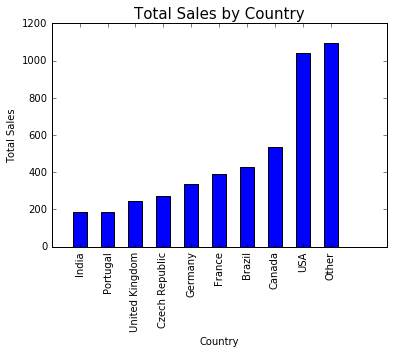

In [26]:
bar_positions = arange(10) + .75
bar_heights = sales_data['total_sales'].values

fig, ax = plt.subplots()
ax.bar(bar_positions, bar_heights, 0.5)

xticks = range(1,11)
ax.set_xticks(xticks)
ax.set_xticklabels(sales_data['country'], rotation=90)
ax.set_xlabel('Country')

ax.set_ylabel('Total Sales')

ax.set_title('Total Sales by Country', fontsize=15)

plt.show()

The United States has the most sales by a long shot, so it should be prioritized in marketing efforts.

Even though all of the "Other" countries only have one customer each, they have more sales combined than the most profitable country, the USA.  Therefore they represent a significant portion of the company's total sales and should not be discarded in marketing.

In [29]:
q = "SELECT country, average_sales_per_customer \
FROM customer_data \
WHERE country IS NOT 'Other' \
ORDER BY 2 ASC"

sales_data = run_query(q)
sales_data

,country,average_sales_per_customer
0,Canada,66.948750
1,France,77.814000
2,USA,80.037692
3,United Kingdom,81.840000
4,Germany,83.655000
5,Brazil,85.536000
6,India,91.575000
7,Portugal,92.565000
8,Czech Republic,136.620000


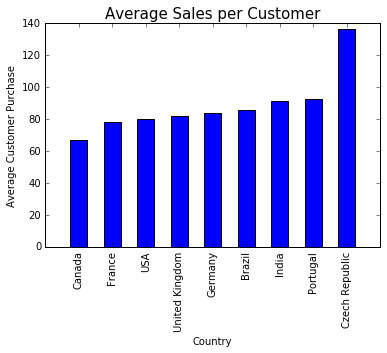

In [31]:
bar_positions = arange(9) + .75
bar_heights = sales_data['average_sales_per_customer'].values

fig, ax = plt.subplots()
ax.bar(bar_positions, bar_heights, 0.5)

xticks = range(1,10)
ax.set_xticks(xticks)
ax.set_xticklabels(sales_data['country'], rotation=90)
ax.set_xlabel('Country')

ax.set_ylabel('Average Customer Purchase')

ax.set_title('Average Sales per Customer', fontsize=15)

plt.show()

In terms of average sales per customer, customers in the Czech Republic clearly spend far more than others and should be prioritized by marketing.  India and Portugal may be areas for growth as well.

The "Other" category was omitted to reduce clutter because it was the second-lowest value of the countries being studied.